# Sentinel 2 - Mapping Pond Inlet Use-case
This walkthrough was a demonstration of reuse of an existing jupyter notebook from Eurodata Cube 'USING SENTINEL HUB PYTHON PACKAGE IN EDC: A STARTER'S GUIDE' repurposed for a usecase in Pond Inlet, Baffin bay, Nunavut, Canada
https://eurodatacube.com/notebooks

Throughout the repurposing of the notebook - I made adjustments to the bounding box to target a sample location of interest (Pond Inlet, Nunavut, Canada). I also adjusted the dates to retrieve sample dates for my area of interest, targeting May of 2018-2023 to look at the variances of sea-ice breakup. 

In [61]:
# EDC libraries
from edc import setup_environment_variables

# Utilities
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from IPython.display import display, Image

# Sentinel Hub
from sentinelhub import (MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, 
                         DataCollection, bbox_to_dimensions, DownloadRequest, SHConfig)

In [62]:
import requests

response = requests.post('https://services.sentinel-hub.com/api/v1/process',
  headers={"Authorization" : "Bearer <your_access_token>"},
  json={
    "input": {
        "bounds": {
            "bbox": [
                -77.251737,
                72.614379,
                -76.276700,
                72.919508
            ]
        },
        "data": [{
            "type": "sentinel-2-l2a"
        }]
    },
    "evalscript": """
    //VERSION=3

    function setup() {
      return {
        input: ["B02", "B03", "B04"],
        output: {
          bands: 3
        }
      };
    }

    function evaluatePixel(
      sample,
      scenes,
      inputMetadata,
      customData,
      outputMetadata
    ) {
      return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
    }
    """
})

In [63]:
# Pass Sentinel Hub credentials to SHConfig
config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]

In [64]:
# Define the plot_image function
def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [65]:
# Configure plots for inline use in Jupyter Notebook
%matplotlib inline

In [66]:
pond_coords_wgs84 = [-77.251737,72.614379,-76.276700,72.919508]

In [67]:
resolution = 60
pond_bbox = BBox(bbox=pond_coords_wgs84, crs=CRS.WGS84)
pond_size = bbox_to_dimensions(pond_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {pond_size} pixels')

Image shape at 60 m resolution: (554, 551) pixels


In [68]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=('2023-09-12', '2023-09-13'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=pond_bbox,
    size=pond_size,
    config=config
)

In [69]:
true_color_imgs = request_true_color.get_data()

In [70]:
print(f'Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.')
print(f'Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}')

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (551, 554, 3)


Image type: uint8


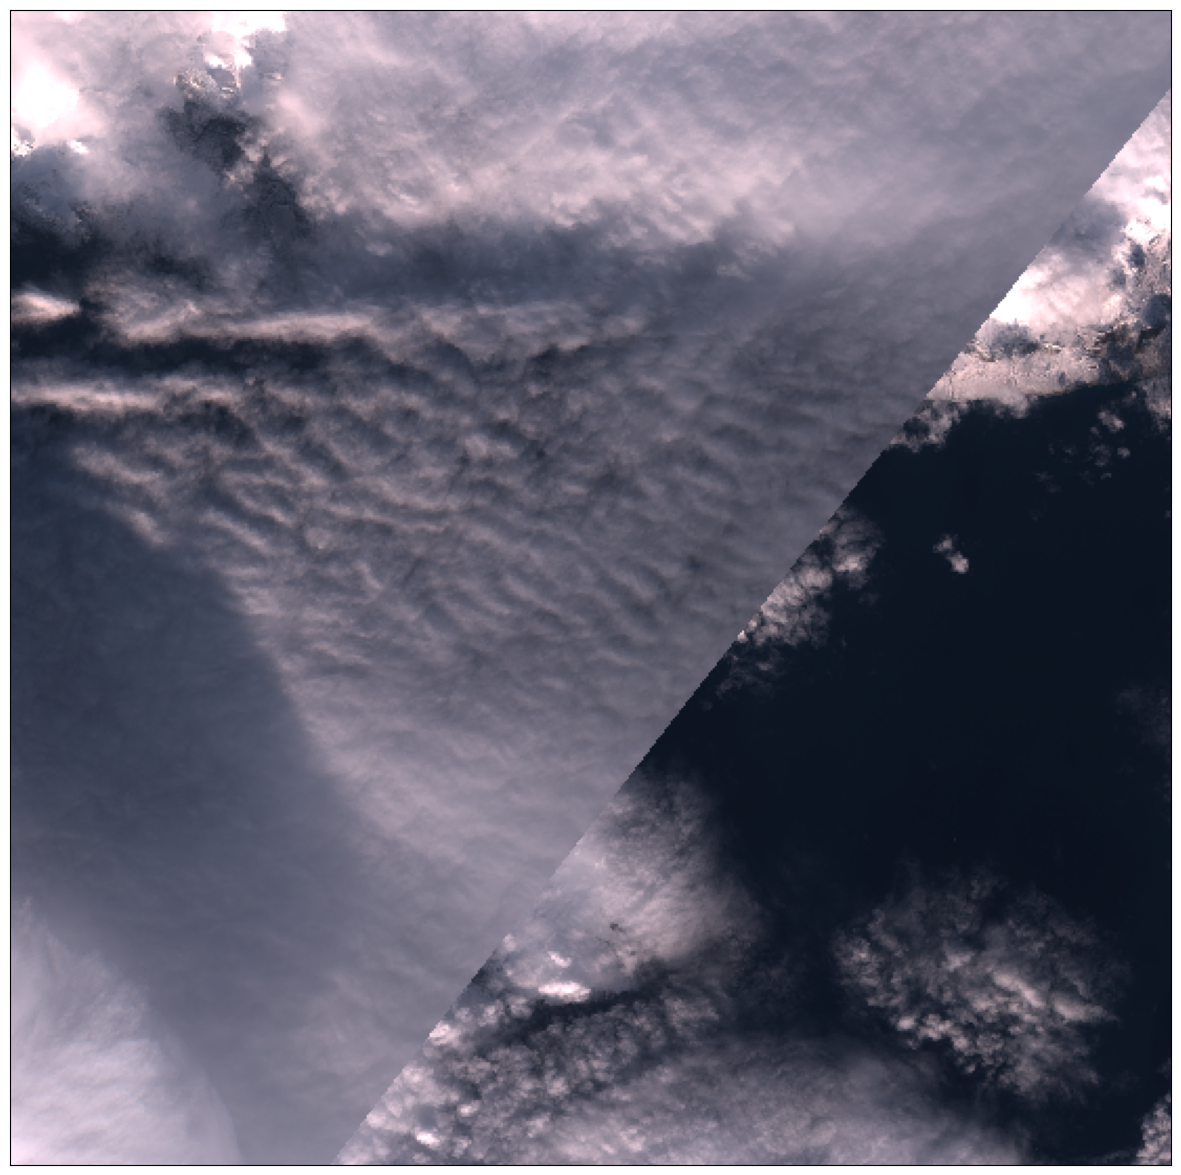

In [71]:
image = true_color_imgs[0]
print(f'Image type: {image.dtype}')

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=1/255, clip_range=(0,1))

In [72]:
evalscript_clm = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B03", "B04", "CLM"],
    output: { bands: 3 }
  }
}

function evaluatePixel(sample) {
  if (sample.CLM == 1) {
    return [0.75 + sample.B04, sample.B03, sample.B02]
  }
  return [3.5*sample.B04, 3.5*sample.B03, 3.5*sample.B02];
}
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_clm,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=('2023-09-15', '2023-09-16'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=pond_bbox,
    size=pond_size,
    config=config
)

In [73]:
data_with_cloud_mask = request_true_color.get_data()

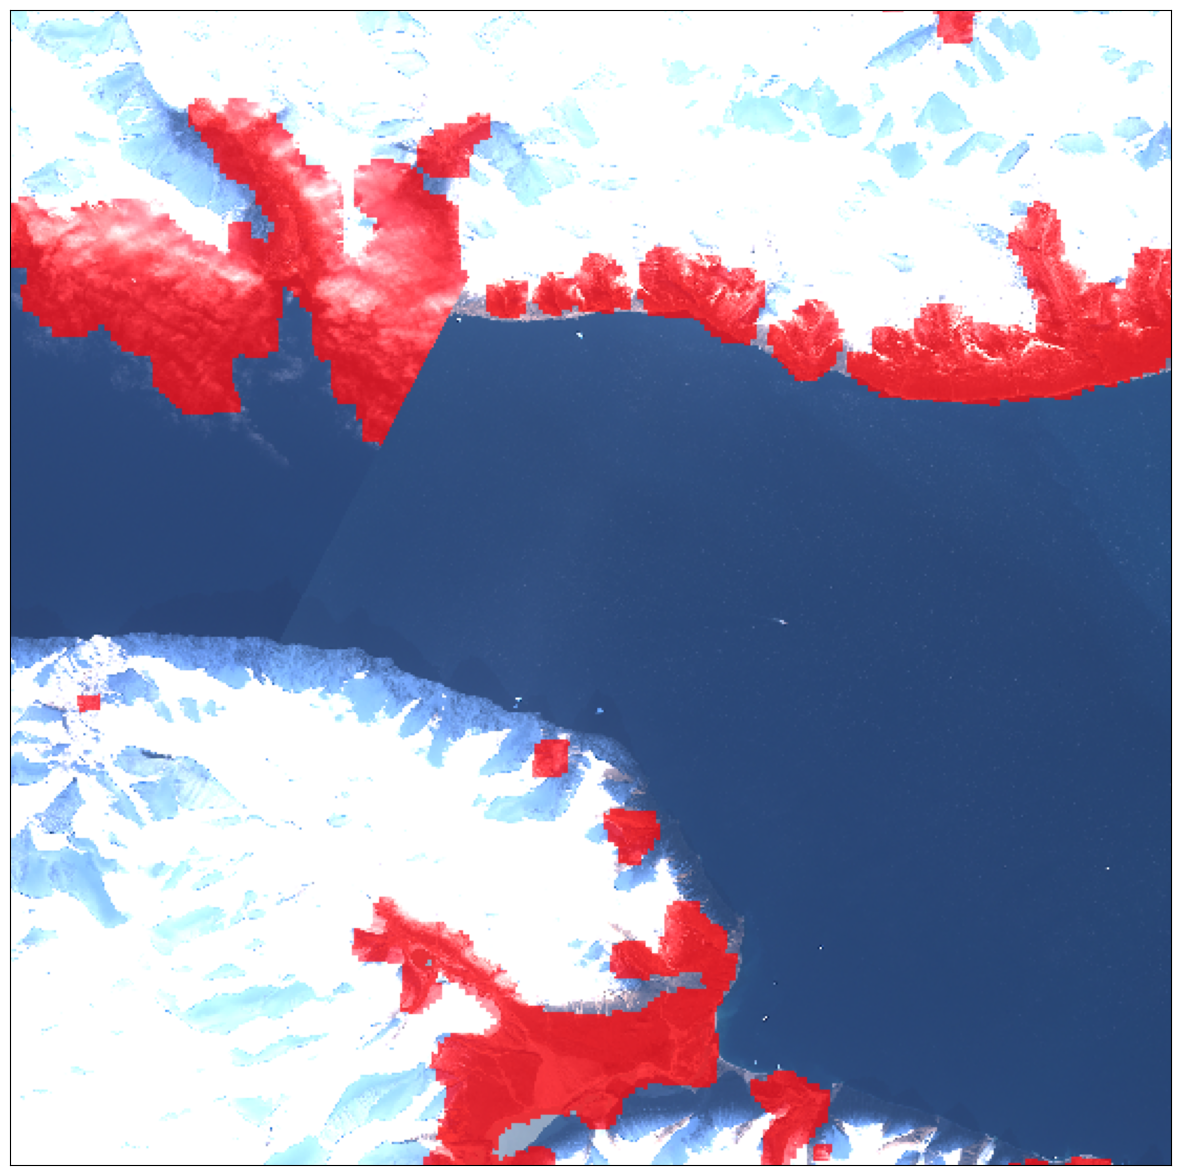

In [74]:
plot_image(data_with_cloud_mask[0], factor=1/255)

In [101]:
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=('2023-06-15', '2023-06-30'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=pond_bbox,
    size=pond_size,
    config=config
)

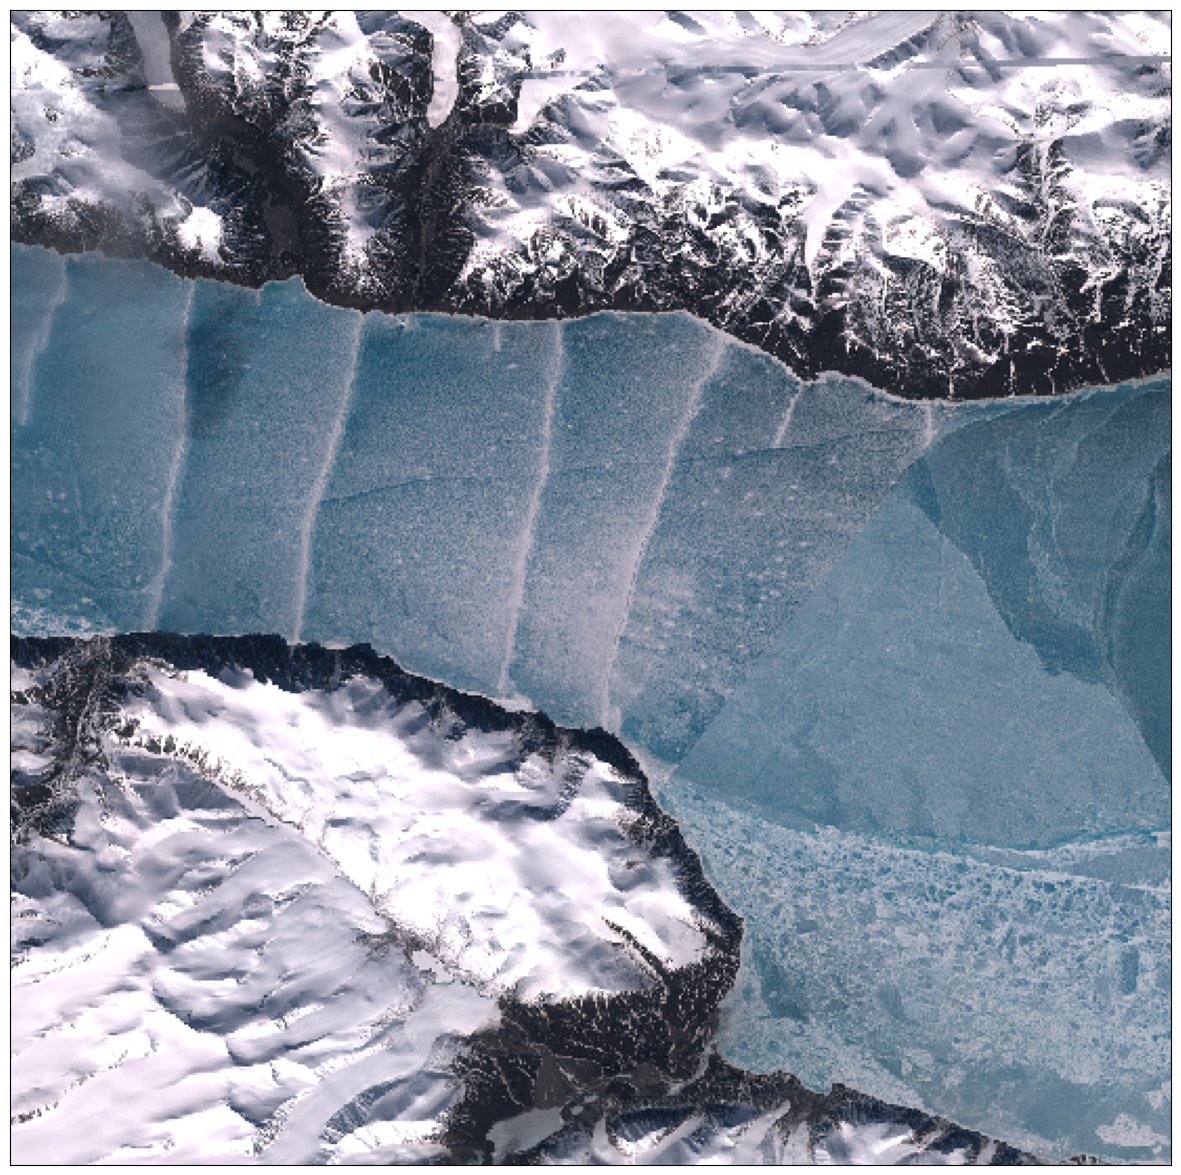

In [102]:
plot_image(request_true_color.get_data()[0], factor=1/250, clip_range=(0,1))

In [23]:
import imagecodecs

In [24]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

request_all_bands = SentinelHubRequest(
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=('2020-06-01', '2020-06-30'),
            mosaicking_order='leastCC'
    )],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=pond_bbox,
    size=pond_size,
    config=config
)

In [25]:
all_bands_response = request_all_bands.get_data()

ValueError: <COMPRESSION.DEFLATE: 32946> requires the 'imagecodecs' package

In [141]:
# Image showing the SWIR band B12
# Factor 1/1e4 due to the DN band values in the range 0-10000
# Factor 3.5 to increase the brightness
plot_image(all_bands_response[0][:, :, 12], factor=3.5/1e4, vmax=1)

NameError: name 'all_bands_response' is not defined